In [97]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset

In [100]:
batch_size=32

In [101]:
transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((.5,), (.5,))])

train_dataset=MNIST(root="~/torch_datasets", train=True, transform=transform, download=True)

test_dataset=MNIST(root="~/torch_datasets", train=False, transform=transform, download=True)


train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)

test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
        

In [102]:
train_dataset[0]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [103]:
def random_noise_generator(batch_size, dim):
    return torch.rand(batch_size, dim)*2-1

In [104]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        #self.conv0_bn = nn.BatchNorm2d(32)
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        #self.conv1_bn = nn.BatchNorm2d(64)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        #self.conv2_bn = nn.BatchNorm2d(128)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        #self.conv3_bn = nn.BatchNorm2d(256)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(12544, 1)
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.leaky_relu(self.conv0(x), 0.2)
        #x = self.conv0_bn(x)
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        #x = self.conv1_bn(x)
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        #x = self.conv2_bn(x)
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        #x = self.conv3_bn(x)
        x = self.conv3_drop(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [105]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100, 256*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        #self.trans_conv1_bn = nn.BatchNorm2d(128)
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        #self.trans_conv2_bn = nn.BatchNorm2d(64)
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        #self.trans_conv3_bn = nn.BatchNorm2d(32)
        self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.trans_conv1(x))
        #x = self.trans_conv1_bn(x)
        x = F.relu(self.trans_conv2(x))
        #x = self.trans_conv2_bn(x)
        x = F.relu(self.trans_conv3(x))
        #x = self.trans_conv3_bn(x)
        x = self.trans_conv4(x)
        x = torch.tanh(x)
        
        return x        

In [106]:
D=Discriminator()
G=Generator()


D = D.float()
G = G.float()



In [107]:
Loss = nn.BCEWithLogitsLoss()
def discriminator_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = Loss(real_out.squeeze(), real_label.squeeze())
    return real_loss

def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = Loss(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss

In [108]:
def generator_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    gen_loss = Loss(gen_disc_out.squeeze(), label.squeeze())
    return gen_loss

In [109]:
disc_opt = optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gen_opt = optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [110]:

real_out=D(train_dataset[0][0])
            

In [111]:
def train(D, G, disc_opt, gen_opt, train_dl, batch_size = 32, epochs = 25, gen_input_size = 100):
    
    disc_losses = []
    gen_losses = []
    
    #Having a fixed sample to monitor the progress of the generator
    sample_size = 16
    fixed_samples = random_noise_generator(sample_size, gen_input_size)
    fixed_samples = fixed_samples.to(device)
    
    #Going into training mode
    D.train()
    G.train()
    
    for epoch in range(epochs + 1):
        
        disc_loss_total = 0
        gen_loss_total = 0
        gen_out = 0
        
        for train_x, _ in train_dl:
            
            #Discriminator training
            disc_opt.zero_grad()
               
            real_out = D(train_x.float())    
            
            disc_gen_in = random_noise_generator(batch_size, gen_input_size)
          
            
            disc_gen_out = G(disc_gen_in.float()).detach()  #Detaching to avoid training the generator
            fake_out = D(disc_gen_out.float())
            
            disc_loss = discriminator_loss(real_out, fake_out)  #Loss calculation
            disc_loss_total += disc_loss
            disc_loss.backward()
            disc_opt.step()  
        
            #Generator training
            gen_opt.zero_grad()
            
            
            gen_out = G(disc_gen_in.float())     #Feeding noise into the generator
            gen_disc_out = D(gen_out.float())       #Passing into the discrminator
            
            gen_loss = generator_loss(gen_disc_out)  #Generator loss calculation
            gen_loss_total += gen_loss
            gen_loss.backward()
            gen_opt.step()
        
        disc_losses.append(disc_loss_total)
        gen_losses.append(gen_loss_total)
        
        #Plotting samples every 5 epochs
        if epoch%5 == 0:
            G.eval()                    #Going into eval mode to get sample images         
            samples = G(fixed_samples.float())
            G.train()                   #Going back into train mode
            
            fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
            for ax, img in zip(axes.flatten(), samples):
               img = img.cpu().detach()
               ax.xaxis.set_visible(False)
               ax.yaxis.set_visible(False)
               im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        
        
        #Printing losses every epoch
        print("Epoch ", epoch, ": Discriminator Loss = ", disc_loss_total/len(train_dl), ", Generator Loss = ", gen_loss_total/len(train_dl))    
    
    return disc_losses, gen_losses

Epoch  0 : Discriminator Loss =  tensor(1.1368, grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.1231, grad_fn=<DivBackward0>)
Epoch  1 : Discriminator Loss =  tensor(1.2093, grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.9913, grad_fn=<DivBackward0>)
Epoch  2 : Discriminator Loss =  tensor(1.1850, grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.0501, grad_fn=<DivBackward0>)
Epoch  3 : Discriminator Loss =  tensor(1.1967, grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.0329, grad_fn=<DivBackward0>)
Epoch  4 : Discriminator Loss =  tensor(1.2144, grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.0104, grad_fn=<DivBackward0>)
Epoch  5 : Discriminator Loss =  tensor(1.2334, grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.9733, grad_fn=<DivBackward0>)
Epoch  6 : Discriminator Loss =  tensor(1.2466, grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.9460, grad_fn=<DivBackward0>)
Epoch  7 : Discriminator Loss =  tensor(1.2597, grad_fn=<DivBackward0>) , Generator

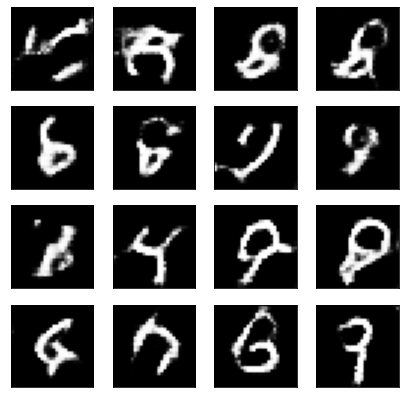

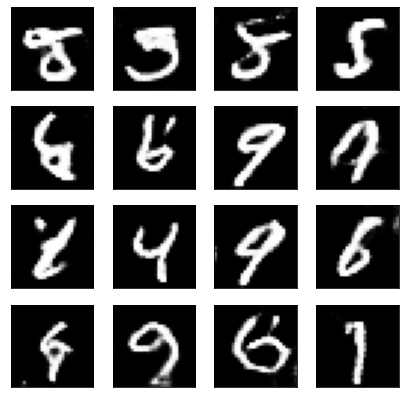

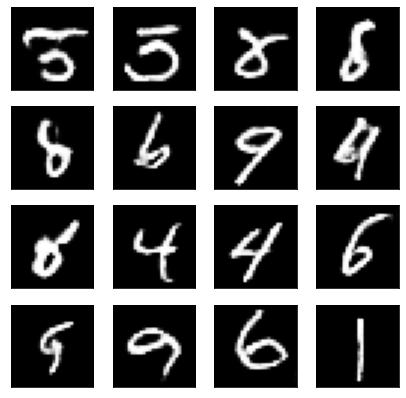

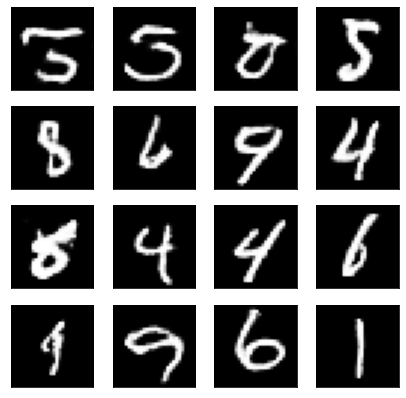

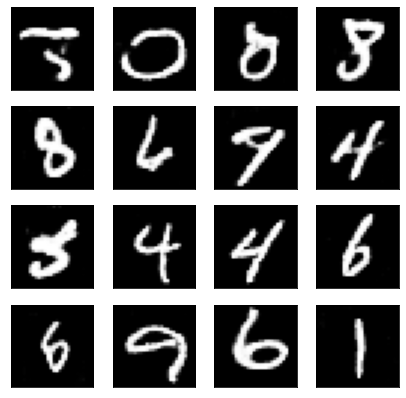

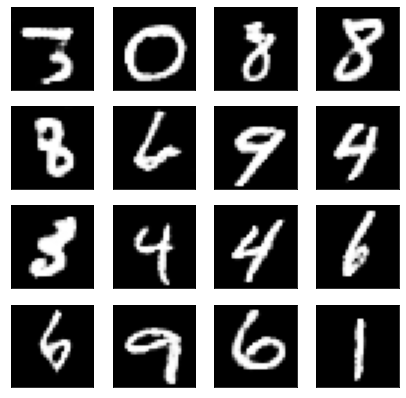

In [112]:
disc_losses, gen_losses = train(D, G, disc_opt, gen_opt, train_loader, batch_size)

In [113]:
torch.save(D.state_dict(), './Disc03.pth')

In [114]:
torch.save(G.state_dict(), './Gen03.pth')